In [6]:
!pip install opencv-python matplotlib
!pip install tensorflow


In [7]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [8]:
#Import tensorflow dependencies - Functional APi
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.2 Create Folder Structures

In [9]:
POS_PATH = os.path.join('data','positive')
NEG_PATH= os.path.join('data','negative')
ANC_PATH = os.path.join('data','anchor')

In [10]:
#Making the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [11]:
#Uncompressed Tar GZ Labelled Faces In the Wild Dataset
!tar -xf lfw.tgz


In [15]:

# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [16]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        print(os.path.join('lfw', directory, file))

In [17]:
#import UUID Lib to generate unique imgae names
import uuid

In [18]:

os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\452b6ee6-729c-11ef-aea6-00155dfc324c.jpg'

In [19]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()


3.1 Get Image Directories

In [26]:

anchor = tf.data.Dataset.list_files(ANC_PATH +'\\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH +'\\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH +'\\*.jpg').take(300)

In [27]:
ANC_PATH + '\\*.jpg'

'data\\anchor\\*.jpg'

In [28]:

dir_test = anchor.as_numpy_iterator()


In [29]:
print(dir_test.next())

b'data\\anchor\\6eddcd9a-7258-11ef-a07c-00155dfc324c.jpg'


3.2 Preprocessing - Scale and Resize


In [30]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [22]:
img = preprocess('data\\anchor\\b6686eca-7259-11ef-a77c-00155dfc324c.jpg')

In [23]:
img.numpy().max()

1.0

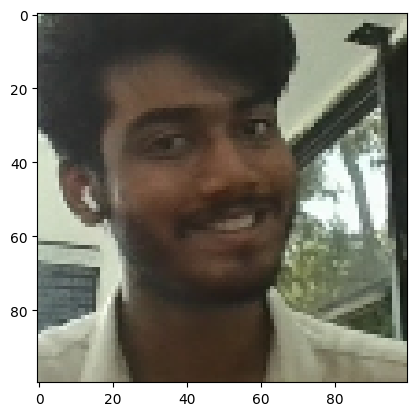

In [31]:
plt.imshow(img)

In [32]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0
tf.ones(len(anchor)).numpy()


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [33]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives) 


In [35]:
samples = data.as_numpy_iterator()

In [36]:
example = samples.next()

In [37]:
example

(b'data\\anchor\\82c20b68-7258-11ef-b328-00155dfc324c.jpg',
 b'data\\positive\\6402c8f4-729c-11ef-9c9c-00155dfc324c.jpg',
 1.0)

In [38]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [39]:
res = preprocess_twin(*example)
res

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.8713235 , 0.91838235, 0.839951  ],
         [0.8723039 , 0.91838235, 0.84289217],
         [0.87083334, 0.9139706 , 0.8473039 ],
         ...,
         [0.6227941 , 0.65416664, 0.5718137 ],
         [0.6343137 , 0.66568625, 0.577451  ],
         [0.64215684, 0.6735294 , 0.5833333 ]],
 
        [[0.87058824, 0.91862744, 0.8421569 ],
         [0.8656863 , 0.9129902 , 0.8367647 ],
         [0.8686274 , 0.9137255 , 0.84411764],
         ...,
         [0.6343137 , 0.66568625, 0.5754902 ],
         [0.65392154, 0.6852941 , 0.595098  ],
         [0.6671569 , 0.6985294 , 0.6073529 ]],
 
        [[0.86764705, 0.91862744, 0.8480392 ],
         [0.8666667 , 0.91764706, 0.845098  ],
         [0.8666667 , 0.91764706, 0.84068626],
         ...,
         [0.6477941 , 0.6791667 , 0.5889706 ],
         [0.685049  , 0.70980394, 0.61960787],
         [0.7495098 , 0.77205884, 0.68088233]],
 
        ...,
 
        [[0.7470588 , 0.7617647 

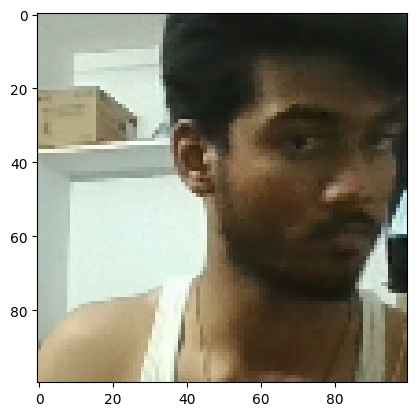

In [40]:
plt.imshow(res[1])

In [41]:
res[2]

1.0

In [42]:

# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [43]:
samples= data.as_numpy_iterator()
len(samples.next())


3

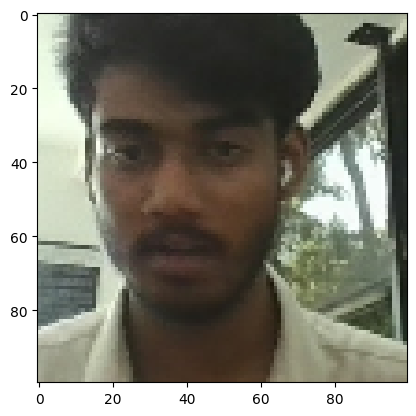

In [44]:
samp = samples.next()
plt.imshow(samp[0])


In [45]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [46]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

4 Model Engineering


In [47]:
inp = Input(shape=(100,100,3), name='Input Image')
c1= Conv2D(64,(10,10),activation='relu')(inp)


In [48]:
m1= MaxPooling2D(64,(2,2),padding='same')(c1)


In [49]:
#Second block
c2=Conv2D(128,(7,7),activation='relu')(m1)
m2= MaxPooling2D(64,(2,2), padding='same')(c2)


In [50]:
#third block
c3= Conv2D(128,(4,4),activation='relu')(m2)
m3 = MaxPooling2D(64,(2,2), padding='same')(c3)


In [51]:
#Final embedding block
c4= Conv2D(256,(4,4),activation='relu')(m3)
f1 = Flatten()(c4)
d1= Dense(4096,activation='sigmoid')(f1)


In [52]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [53]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input Image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

4.1 Building Embedding layer

In [54]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [55]:
embedding = make_embedding()

In [56]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

4.2 Building Distance Layer

In [57]:
class L1Dist(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(L1Dist, self).__init__(**kwargs)

    def call(self, input_embedding, validation_embedding):
        # Ensure input_embedding and validation_embedding are tensors
        input_embedding = tf.convert_to_tensor(input_embedding)
        validation_embedding = tf.convert_to_tensor(validation_embedding)
        
        # Perform element-wise subtraction
        difference = input_embedding - validation_embedding
        
        # Calculate the absolute value element-wise
        return tf.math.abs(difference)

In [58]:
l1 = L1Dist()

In [59]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

4.3 Make Siamese Model

In [60]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [61]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [62]:
siamese_layer = L1Dist()

In [63]:
siamese_layer(inp_embedding, val_embedding)

<KerasTensor shape=(1, None, 4096), dtype=float32, sparse=False, name=keras_tensor_20>

In [64]:
distances = siamese_layer(inp_embedding, val_embedding)

In [65]:
classifier = Dense(1, activation='sigmoid')(distances)

In [66]:
classifier

<KerasTensor shape=(1, None, 1), dtype=float32, sparse=False, name=keras_tensor_22>

In [67]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [68]:

siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (1, None, 4096)   │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (1, None, 1)      │      4,097 │ l1_dist_1[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [70]:
siamese_model = make_siamese_model()

In [71]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_2 (L1Dist)  │ (1, None, 4096)   │          0 │ embedding[2][0],  │
│                     │                   │            │ embedding[3][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (1, None, 1)      │      4,097 │ l1_dist_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

## Training


### 5.1 Setup Loss and Optimizer

In [72]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [73]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

### 5.2 Establish Checkpoints

In [74]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

### 5.3 Build Train Step Function


In [75]:
test_batch = train_data.as_numpy_iterator()

In [76]:
batch_1 = test_batch.next()


In [77]:
x = batch_1[:2]

In [78]:
y = batch_1[2]
y

array([1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1.],
      dtype=float32)

In [79]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape: #Helps in  calculation the automatic Differentiation
        # Get anchor and Pos/Neg image
        x = batch[:2]
        #Get label
        y= batch[2]

        #Forward Pass
        yhat = siamese_model(x, training =True)
        yhat = tf.squeeze(yhat, axis=[0, 2])
        #calculate Loss
        loss = binary_cross_loss(y, yhat)
        print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

In [80]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [81]:
EPOCHS = 50

In [82]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/Mean:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/Mean:0", shape=(), dtype=float32)
14/15 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepTensor("binary_crossentropy/Mean:0", shape=(), dtype=float32)
15/15 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step

 Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step

 Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step

 Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step

 Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step

 Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step

 Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step

 Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step

 Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step

 Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step

 Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step

 Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step

 Epoch 13/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step

 Epoch 14/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step

 Epoch 15/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 39s

In [83]:
from tensorflow .keras.metrics import Precision, Recall

In [84]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [85]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step


array([[[1.0000000e+00],
        [9.9983573e-01],
        [9.9926049e-01],
        [9.9999851e-01],
        [9.9952143e-01],
        [1.9625334e-11],
        [2.8244099e-07],
        [1.0000000e+00],
        [9.9990052e-01],
        [4.5064592e-08],
        [2.0176453e-11],
        [3.9786865e-10],
        [9.9990839e-01],
        [2.2450332e-10],
        [2.7470545e-10],
        [1.9732009e-11]]], dtype=float32)

In [86]:
# Post processing the results 
y_true

array([1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.],
      dtype=float32)

In [87]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [88]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

### Visualize Results

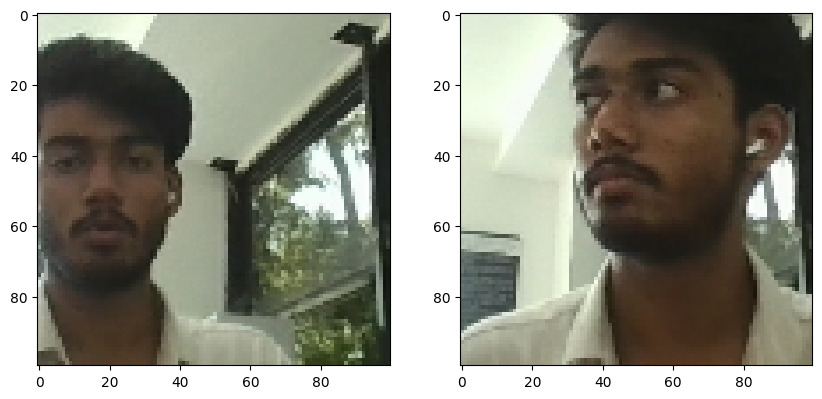

In [89]:
#Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[2])

# Renders cleanly
plt.show()

In [90]:
siamese_model.save('siamesemodel.h5')

In [91]:
L1Dist

__main__.L1Dist

In [92]:
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [93]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step


array([[[1.0000000e+00],
        [9.9983573e-01],
        [9.9926049e-01],
        [9.9999851e-01],
        [9.9952143e-01],
        [1.9625334e-11],
        [2.8244099e-07],
        [1.0000000e+00],
        [9.9990052e-01],
        [4.5064592e-08],
        [2.0176453e-11],
        [3.9786865e-10],
        [9.9990839e-01],
        [2.2450332e-10],
        [2.7470545e-10],
        [1.9732009e-11]]], dtype=float32)

In [94]:
 # View model summary
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_2 (L1Dist)  │ (1, None, 4096)   │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (1, None, 1)      │      4,097 │ l1_dist_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# Real Time Test

In [ ]:
application_data\verification_images

In [95]:
os.listdir(os.path.join('application_data','verification_images'))

['34234364-7259-11ef-887a-00155dfc324c.jpg',
 '3490f860-7259-11ef-9636-00155dfc324c.jpg',
 '351c01a6-7259-11ef-bead-00155dfc324c.jpg',
 '356b59b6-7259-11ef-80a2-00155dfc324c.jpg',
 '379fd7c3-7259-11ef-a9f7-00155dfc324c.jpg',
 '385bb5dc-7259-11ef-9ed8-00155dfc324c.jpg',
 '387b10e6-7259-11ef-88ed-00155dfc324c.jpg',
 '390cd318-7259-11ef-8423-00155dfc324c.jpg',
 '3992c249-7259-11ef-b74b-00155dfc324c.jpg',
 '56c69ecf-729c-11ef-b0e0-00155dfc324c.jpg',
 '571edaef-729c-11ef-8abe-00155dfc324c.jpg',
 '63d4274c-729c-11ef-8eef-00155dfc324c.jpg',
 '6402c8f4-729c-11ef-9c9c-00155dfc324c.jpg',
 '6554d07c-729c-11ef-aa40-00155dfc324c.jpg',
 '668c99c9-7259-11ef-bcf0-00155dfc324c.jpg',
 '672e2b63-7259-11ef-ba77-00155dfc324c.jpg',
 '6779e018-7259-11ef-8810-00155dfc324c.jpg',
 '67cfb367-7259-11ef-8b5d-00155dfc324c.jpg',
 '67e92293-7259-11ef-b227-00155dfc324c.jpg',
 '680475e5-7259-11ef-a074-00155dfc324c.jpg',
 '68814218-7259-11ef-84dd-00155dfc324c.jpg',
 '68a1e8d3-729c-11ef-b0f4-00155dfc324c.jpg',
 '68bdc83f

In [96]:
os.path.join('application_data','input_image','input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [97]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\34234364-7259-11ef-887a-00155dfc324c.jpg
application_data\verification_images\3490f860-7259-11ef-9636-00155dfc324c.jpg
application_data\verification_images\351c01a6-7259-11ef-bead-00155dfc324c.jpg
application_data\verification_images\356b59b6-7259-11ef-80a2-00155dfc324c.jpg
application_data\verification_images\379fd7c3-7259-11ef-a9f7-00155dfc324c.jpg
application_data\verification_images\385bb5dc-7259-11ef-9ed8-00155dfc324c.jpg
application_data\verification_images\387b10e6-7259-11ef-88ed-00155dfc324c.jpg
application_data\verification_images\390cd318-7259-11ef-8423-00155dfc324c.jpg
application_data\verification_images\3992c249-7259-11ef-b74b-00155dfc324c.jpg
application_data\verification_images\56c69ecf-729c-11ef-b0e0-00155dfc324c.jpg
application_data\verification_images\571edaef-729c-11ef-8abe-00155dfc324c.jpg
application_data\verification_images\63d4274c-729c-11ef-8eef-00155dfc324c.jpg
application_data\verification_images\6402c8f4-729c-11ef-9c9c-001

In [98]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [99]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━

In [ ]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_23 (L1Dist) │ (1, None, 4096)   │          0 │ embedding[10][0], │
│                     │                   │            │ embedding[11][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (1, None, 1)      │      4,097 │ l1_dist_23[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)